<span style="font-size:30pt;font-weight:bold">Home Credit Python Scoring Workflow v.0.7.0</font>

**Copyright:**

© 2017-2018, Pavel Sůva, Marek Teller, Martin Kotek, Jan Zeller, Marek Mukenšnabl, Kirill Odintsov, Jan Hynek, Elena Kuchina and Home Credit & Finance Bank Limited Liability Company, Moscow, Russia – all rights reserved

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the [License](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


**Contributors:**
- Pavel Sůva (HCI Research & Development)
- Sergey Gerasimov (HCRU Scoring & Big Data)
- Valentina Kalenichenko (HCRU Scoring & Big Data)
- Marek Teller (HCI Research & Development)
- Martin Kotek (HCCN Risk Decision & Big Data)
- Jan Zeller
- Marek Mukenšnabl (HCI Research & Development)
- Anatoliy Glushenko (HCRU Scoring & Big Data)
- Kirill Odintsov (HCI Research & Development)
- Jan Hynek (HCI Research & Development)
- Elena Kuchina (HCI Research & Development)
- Dmitry Gorev (HCRU Scoring & Big Data)

# Import packages

## List of packages
- `time`, datetime - ability to get current time for logs
- `math` - basic mathematical functions (as logarithm etc.))
- `random` - generate random selection from probability distributions
- `NumPy` - for scientific, mathematical, numerical calculations
- `Scipy` - for clustering and correlation calculations
- `Pandas` - for efficient work with large data structures (you need pandas **version 0.23 or higher**)
- `cx_Oracle` and sqlalchemy - for loading data from Oracle database (DWH etc.)
- `scikit`-learn - all important machine learning (and statistical) algorithms used for training the models
- `matplotlib` - for plotting the charts
- `seaborn` - for statistical visualisations
- `os` - for setting output paths for generated image files
- `pickle` - to save models to external files
- `tqdm` - intelligent progress bar
- `tkinter` - for interactive Interactions tool GUI
- `xgboost` - gradient boosting used for feature selection before regression

**If any of these packages is missing, you have to install it from the Anaconda prompt using command *conda install packagename* where *packagename* is the name of the installed package.**

There is another package called *scoring*, which is distributed along with this workflow. **The folder *scoring* must be located in the same folder as this workflow for the package to be loaded correctly.** Alternatively, you can locate it somewhere else and then use *sys.path.insert()* to map this location.

## Other important prerequisites

For the grouping some **extensions for Jupyter must be installed and enabled before Jupyter is started and the notebook is loaded**. These extensions are Javascripts running in the browser, so it is necessary to have a compatibile browser. Generally, Chrome is OK, Internet Explorer 11 is NOT OK. To install the extensions, run this in your Anaconda prompt:

- `conda install ipywidgets`
- `jupyter nbextension enable --py --sys-prefix widgetsnbextension`
- `conda config --add channels conda-forge`
- `conda install qgrid` 
- `jupyter nbextension enable --py --sys-prefix qgrid`
- `conda install tqdm`

Please, make sure that qgrid library that you installed in this step is **verison 1.0.3 or higher**. 

To be able to connect to Oracle database (to get the data directly from your DWH) you need a compatibile Oracle driver to be installed on your computer. **With 64-bit Python, you need to have 64-bit Oracle driver installed.** Before you install the driver, you need to have Java 8 JDK (JRE is not enough) installed on your computer.

In [113]:
import time
import datetime
import operator
import math
import random
import numpy as np
import pandas as pd
# import cx_Oracle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import pickle
import gc
from tqdm import tqdm_notebook as tqdm
#import tkinter
#import xgboost as xgb

import sys

sys.path.append(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Scoring Workflow")
import scoring
#import importlib
#importlib.reload(scoring)

# import warnings
# warnings.filterwarnings('ignore')
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Bureau Imputed Income")

Set general technical parameters and paths.

In [114]:
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True
from IPython.display import display, Markdown
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
output_folder = 'documentation'

if not os.path.exists(output_folder): os.makedirs(output_folder)
if not os.path.exists(output_folder+'/performance'): os.makedirs(output_folder+'/performance')
if not os.path.exists(output_folder+'/predictors'): os.makedirs(output_folder+'/predictors')
if not os.path.exists(output_folder+'/stability'): os.makedirs(output_folder+'/stability')
if not os.path.exists(output_folder+'/stability_short'): os.makedirs(output_folder+'/stability_short')
if not os.path.exists(output_folder+'/analysis'): os.makedirs(output_folder+'/analysis')
if not os.path.exists(output_folder+'/model'): os.makedirs(output_folder+'/model')
if not os.path.exists(output_folder+'/nan_share'): os.makedirs(output_folder+'/nan_share')
scoring.check_version('0.7.0')

# Input data

## Import data
Importing data from a CSV file. It is important to set the following parameters:

encoding: usually 'utf-8' or windows-xxxx on Windows machines, where xxxx is 1250 for Central Europe, 1251 for Cyrilic etc.
sep: separator of columns in the file
decimal: decimal dot or coma
index_col: which columns is used as index - should be the unique credit case identifier

**Defining NA values:** In different datasets, there can be different values to be considered *N/A*. By default, we set only blank fields to be considered *N/A*, however you might want to change it and add values like *'NA'*, *'NAN'*, *'null'* to be also considered *N/A*. User parameter `na_values` for this.

In [115]:
from scoring import db
data = db.read_csv(os.getcwd()+r'\Data Files\binning_dump.CSV', sep = ',', decimal = '.',
                   optimize_types=True, encoding = 'utf-8', index_col = 'SKP_CREDIT_CASE', low_memory = False,
                   keep_default_na = False, na_values = [''])
print('Data loaded on',datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Data loaded on 2021-03-05 10:20:33


The data need to have index column which has unique value per each row. If not, it can cause some problems later. Run this to deal with such rows:

In [116]:
df= data
print(df.PRODUCT_GROUP.value_counts())
print(df.CLIENT_EXI_3M.value_counts())
print(df.DECISION_OVERALL.value_counts())
print(df.FLAG_1PCT_PHANTOM.value_counts())


CD          990791
CL           56973
ACL          14061
VAS           3885
EMI           3751
ACL_MI        2348
ACL_MOBI      2345
TW            1445
OTHERS          14
Name: PRODUCT_GROUP, dtype: int64
N    642562
Y    433051
Name: CLIENT_EXI_3M, dtype: int64
Approved    1075613
Name: DECISION_OVERALL, dtype: int64
0    1053177
1      22436
Name: FLAG_1PCT_PHANTOM, dtype: int64


In [117]:
data.head()

,TIME_DECISION_DATE,PRODUCT_GROUP,DECISION_OVERALL,CLIENT_EXI_3M,SCORE_CB,FLAG_1PCT_PHANTOM,RISK_AGRF30,RISK_FPD30,RISK_AGRF90,RISK_FSTPD30,RISK_AGRF120,RISK_FSTQPD30,CLIENT_EMI,PERFIOS_DISPOSABLE_INCOME,YODLEE_DISPOSABLE_INCOME,SDK_DISPOSABLE_INCOME,CIBIL_IMPUTED_INCOME,ACTIVE_DEBT,TRADELINE_COUNT
SKP_CREDIT_CASE,,,,,,,,,,,,,,,,,,,
304771296,02-06-20,ACL,Approved,Y,734.0,0,1,0,1,0,1,0,3529.0,NaN,32783.48,35915.0,9534.42,11134.0,6.0
304879436,02-06-20,ACL_MOBI,Approved,N,750.0,0,1,0,1,0,1,0,3151.0,NaN,NaN,NaN,663.32,206.0,1.0
305393836,01-06-20,ACL,Approved,Y,739.0,0,0,0,0,0,0,0,2696.0,NaN,16222.17,4475.0,30007.18,1128.0,17.0
305402347,03-06-20,ACL_MOBI,Approved,N,781.0,0,1,0,1,0,1,0,5272.0,NaN,NaN,NaN,100000.00,51495.0,11.0
305435934,01-06-20,CL,Approved,Y,746.0,0,0,0,0,0,0,0,9454.0,NaN,NaN,NaN,11572.68,5173.0,7.0


In [118]:
data["DBI"] = data["CLIENT_EMI"] /(data["CIBIL_IMPUTED_INCOME"]*0.7-data["ACTIVE_DEBT"])

In [119]:
data["DBI"].isna().value_counts()

False    698966
True     376647
Name: DBI, dtype: int64

In [120]:
data = data[data["RISK_AGRF120"]==1]

In [121]:
data= data[["TIME_DECISION_DATE","DBI","RISK_FSTQPD30"]]

In [122]:
# data.info()

In [123]:
#Option 1: remove rows with duplicated index
data=data[~data.index.duplicated(keep='first')]

#Option 2: reset index
#data.reset_index(inplace=True)

Optionally the data can be loaded also from a database. The function read_sql uses cache, so the data don't have to be downloaded from the database repeatedly. The cache will be located in a new folder called **db_cache**.

In [124]:
# from sqlalchemy import create_engine
#engine = create_engine('oracle://PAVELS[GP_HQ_RISK]:xxx@(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST=DBDWHRU.HOMECREDIT.RU)(PORT=1521))(CONNECT_DATA=(SERVICE_NAME=DWHRU)))', echo=False)

In [125]:
#from scoring.db import read_sql
#ru_data = read_sql('select * from owner_dwh.f_application_tt where rownum<11',engine, index_col = 'sk_application')
#print('Data loaded on',datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

If you need to download data from the database again (and not from cache), use the parameter refresh:

In [126]:
#from scoring.db import read_sql
#data = read_sql('select * from owner_dwh.f_application_base_tt where rownum=1',engine, index_col = 'skp_application',refresh=True)
#print('Data loaded on',datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

In [127]:
print('Number of rows:',data.shape[0])
print('Number of columns:',data.shape[1])

Number of rows: 633379
Number of columns: 3


## Metadata definitions
Assigning ID column, target column, time column and month column. The month column don't have to exist in the dataset, it will be created later in this workflow.

In [128]:
### THESE COLUMNS MUST BE INCLUDED IN THE DATA SET ###
#name of the target column
col_target = "RISK_FSTQPD30"
#name of the time column
col_time = "TIME_DECISION_DATE"

### THESE COLUMNS DON'T HAVE TO BE INCLUDED IN THE DATA SET AND ARE CREATED AUTOMATICALLY LATER ###
#name of the base column
col_base = "BASE"
#name of the month column
col_month = "MONTH"
#name of the day column
col_day = "DAY"
#name of the weight column - CURRENTLY COMMENTED OUT BECAUSE OF REASONS MENTIONED LATER
col_weight = 'WEIGHT'
#name of the reject column - only use if exists in your data, used for reject inference analysis
col_reject = 'REJECTED'

In [129]:
pd.DataFrame.from_records([['col_time',col_time],['col_month',col_month],['col_day',col_day],['col_target',col_target],['col_base',col_base]]) \
.to_csv(output_folder+'/model/metadata.csv',index=0,header=None)

data[col_target] = data[col_target].astype(np.float)

If you don't have base column in your data set, the following code adds it (based on if target is filled).

In [130]:
if col_base not in data:
    data[col_base] = 0
    data.loc[data[col_target]==0,col_base] = 1
    data.loc[data[col_target]==1,col_base] = 1
    print('Column',col_base,'added/modified. Number of columns:',data.shape[1])
else:
    print('Column',col_base,'already exists.')

Column BASE added/modified. Number of columns: 4


If you don't have weight column in your data set, the following code adds it, with value = 1 for each row. **The weights are currently supported by Data Exploration, Interactive Grouping and Model Selection (L1 regression and Stepwise) classes, but not by all functions in the workflow. This is why they are commented out now (can be uncommented by the user).**

In [131]:
# if col_weight not in data:
#    data[col_weight] = 1
#    print('Column',col_weight,'added/modified. Number of columns:',data.shape[1])
# else:
#    print('Column',col_weight,'already exists.')

Create the month and day column from the time column is doing the following
- take the time column and tell in which format the time is saved in - **you need to specify this in variable *dtime_input_format*** (see https://docs.python.org/3/library/time.html#time.strftime for reference)
- strip the format just to year, month, day string
- convert the string to number
- the new column will be added to the dataset as day
- truncate this column to just year and month and add it to dataset as month

In [132]:
dtime_input_format = '%d-%m-%y'

In [133]:
data[col_day] = list(pd.to_numeric(pd.to_datetime(data[col_time], format=dtime_input_format).dt.strftime('%Y%m%d')))
data[col_month] = data[col_day].apply(lambda x: math.trunc(x/100))
data[col_time] = pd.to_datetime(data[col_time], format = dtime_input_format)
print('Columns',col_day,'and',col_month,'added/modified. Number of columns:',data.shape[1])

Columns DAY and MONTH added/modified. Number of columns: 6


In [134]:
data.head(5)

,TIME_DECISION_DATE,DBI,RISK_FSTQPD30,BASE,DAY,MONTH
SKP_CREDIT_CASE,,,,,,
304771296,2020-06-02,-0.791272,0.0,1,20200602,202006
304879436,2020-06-02,12.197860,0.0,1,20200602,202006
305402347,2020-06-03,0.284896,0.0,1,20200603,202006
305436020,2020-06-09,-1.343819,0.0,1,20200609,202006
305441848,2020-06-03,-0.402443,0.0,1,20200603,202006


Load the predictors list from a csv file. The csv should have just one column, without any header, containing the name of the variables that should be used as predictors.

Support for boolean predictors in **not** currently implemented. Convert boolean predictors to object to use them.

`s = s.apply(lambda value: str(value) if not np.isnan(value) else value).astype('object')`

In [135]:
data.columns

Index(['TIME_DECISION_DATE', 'DBI', 'RISK_FSTQPD30', 'BASE', 'DAY', 'MONTH'], dtype='object')

In [136]:
from scoring.data_manipulation import split_predictors_bytype

cols_pred = list(['DBI'])

cols_pred, cols_pred_num, cols_pred_cat = split_predictors_bytype(data,
                                                                  pred_list=cols_pred,
                                                                  non_pred_list= [],
                                                                  optimize_types=True,
                                                                  convert_bool2int=True)

List of numerical predictors: [1]

DBI                                 float64

List of categorical predictors: [0]



**Please check if all predictors were categorized correctly.** 
`Category` dtype is now used for categorical columns for memory efficiency. This means it will not be editable as *string*. If you need to edit values of a categorical column convert it to *string* using this syntax:

`data['Column name'] = data['Column name'].astype(str)`



## Data exploration

In [137]:
descrip = data.describe(include='all').transpose()
pd.options.display.max_rows = 1000
display(descrip)
pd.options.display.max_rows = 15

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
TIME_DECISION_DATE,633379,125,2020-09-08,9378,2020-06-01,2020-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DBI,408421,NaN,NaT,NaN,NaT,NaT,inf,NaN,-3000,0.189441,0.451805,1.0088,inf
RISK_FSTQPD30,633379,NaN,NaT,NaN,NaT,NaT,0.0572485,0.232317,0,0,0,0,1
BASE,633379,NaN,NaT,NaN,NaT,NaT,1,0,1,1,1,1,1
DAY,633379,NaN,NaT,NaN,NaT,NaT,2.02008e+07,120.178,2.02006e+07,2.02006e+07,2.02008e+07,2.02009e+07,2.0201e+07
MONTH,633379,NaN,NaT,NaN,NaT,NaT,202008,1.20921,202006,202006,202008,202009,202010


**explore_numerical** and **explore_categorical** functions give graphical data exploratory analyses. They can also output into html files. You just need to specify the folder for output.

If you want the detailed legacy HTML output (v0.4.3) comment-out the cell below

These functions analyze only the part of data where target is not null even if it is not explicitly specified.

In [138]:
data[cols_pred].shape

(633379, 1)

In [139]:
from scoring.data_exploration import explore_categorical, explore_numerical, join_explorations

explored_columns = list()
for name, column in tqdm(data[cols_pred].iloc[0:200000,].iteritems(), total=len(cols_pred), leave=False):
    if name in cols_pred_num[:]:
        if (column.count() > 0) and (column.max() != column.min()):
            explore_numerical(column, data[col_target].iloc[0:200000,], weightCol=None, htmlOut=True, ntbOut=False, outFolder='exp')
            explored_columns.append(name)
    if name in cols_pred_cat[:]:
        if (column.count() > 0) and (len(set(column.unique()) - {np.nan}) > 1):
            explore_categorical(column, data[col_target].iloc[0:200000,], weightCol=None, htmlOut=True, ntbOut=False, outFolder='exp')
            explored_columns.append(name)
            
#comment out the line below if you didn't generate html files in this cell        
join_explorations(explored_columns, filename = '_exploration.html', outFolder='exp', weighted=False)  

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:137: RuntimeWarning: invalid value encountered in subtract
  return self.data - self.mean
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:137: RuntimeWarning: invalid value encountered in subtract
  return self.data - self.mean
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:137: RuntimeWarning: invalid value encountered in subtract
  return self.data - self.mean
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\tile.py:272: RuntimeWarning: invalid value encountered in less
  if (np.diff(bins.astype("float64")) < 

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000237417B1510> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000237417B1158> (for post_execute):


KeyboardInterrupt: 

**explore_df** function creates a simple text report about the important variable. The report can be then printed either to the screen or to a file.

In the following code, only such part of data that has col_base = 1 is analyzed. You can remove the condition if you wish.

In [140]:
from scoring.data_exploration import explore_df
st = explore_df(data[data[col_base]==1],col_month,col_target,cols_pred)
print(st, file=open("data_exp.txt", "w", encoding='utf-8'))
# print(st)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


**Default rate in time**: Simple visualisation of observation count and default rate in time

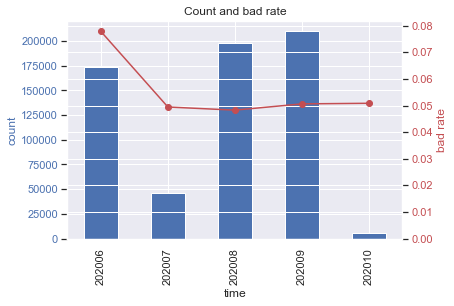

In [141]:
from scoring.plot import plot_dataset
plot_dataset(data,
             month_col=col_month,
             def_col=col_target,
             title='Count and bad rate',
             base_col=col_base,
             #weightCol=col_weight,
             savepath=output_folder+'/analysis/',
             zeroYlim=True)

**NaN share by month** for each variable in dataset:

Calculating NaN shares...
Making images...


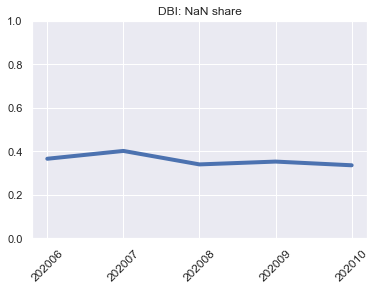

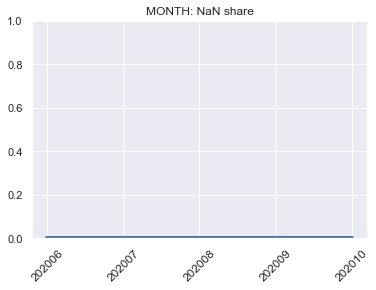

MONTH,202006,202007,202008,202009,202010
DBI,0.365,0.401,0.339,0.352,0.335
MONTH,0.000,0.000,0.000,0.000,0.000


In [142]:
from scoring.data_exploration import nan_share_development

nan_table = nan_share_development(data[cols_pred + [col_month]], col_month, 
                                  make_images=True, show_images=True, output_path=output_folder+'/nan_share/')
display(nan_table)

## Data split

- Split data into five parts (in time training, in time validation, in time test, out of time, historical out of time)
- Adds a new column indicating to which part the observations belong
- The *splitting_points* (first date of train and first date of out of time sample) can be adjusted (there can be any number of such splitting points) - it should correspond to values of column specified by *time_column* parameter
- For each time split, you can create multiple random splits (i.e. train/valid/test), the ratio of sizes of these splits is set by parameter *sample_sizes*
- The random splits can be stratified by multiple variables, which are specified in a list - argument to *stratify_by_columns* parameter
- Set the random seed so the results are replicable

In [143]:
from scoring.data_manipulation import data_sample_time_split

data['data_type'] = data_sample_time_split(data, 
                           time_column = col_month,
                           splitting_points = [202008, 202101],
                           sample_sizes = [[ 1    ],[ 0.6   , 0.2   , 0.2  ],[ 1   ]],
                           sample_names = [['hoot'],['train','valid','test'],['oot']],
                           stratify_by_columns = [col_month,col_target],
                           random_seed = 1234)

hoot    219,980 rows
train   248,039 rows
valid   82,680 rows
test    82,680 rows
oot     0 rows


Masks: boolean vectors corresponding to rows in the datasets. True if an row is observable and its data type belongs to given sample.

In [144]:
train_mask = (data['data_type'] == 'train') & (data[col_base] == 1) 
valid_mask = (data['data_type'] == 'valid') & (data[col_base] == 1) 
test_mask = (data['data_type'] == 'test') & (data[col_base] == 1) 
oot_mask = (data['data_type'] == 'oot') & (data[col_base] == 1) 
hoot_mask = (data['data_type'] == 'hoot') & (data[col_base] == 1) 

Data summary (number of defaults, number in base, number of observations, default rate) by month and by sample

In [145]:
data_summary = data.groupby([col_month,'data_type']).aggregate({
    col_target:'sum',col_base:['sum','count']
})
data_summary.columns = [col_target,col_base,'Rows']
data_summary[col_target+' rate'] = data_summary[col_target]/data_summary[col_base]
display(data_summary)

data_summary = data_summary.reset_index(level='data_type').pivot(columns='data_type')
display(data_summary)
data_summary.to_csv(output_folder+'/analysis/summary.csv')

RISK_FSTQPD30    BASE    Rows  RISK_FSTQPD30 rate
MONTH  data_type                                                   
202006 hoot             13507.0  173554  173554            0.077826
202007 hoot              2295.0   46426   46426            0.049434
202008 test              1911.0   39604   39604            0.048253
       train             5734.0  118812  118812            0.048261
       valid             1911.0   39604   39604            0.048253
202009 test              2122.0   41939   41939            0.050597
       train             6368.0  125816  125816            0.050614
       valid             2123.0   41939   41939            0.050621
202010 test                58.0    1137    1137            0.051011
       train              173.0    3411    3411            0.050718
       valid               58.0    1137    1137            0.051011

RISK_FSTQPD30                              BASE                     \
data_type          hoot    test   train   valid      hoot     test     train   
MONTH                                                                          
202006          13507.0     NaN     NaN     NaN  173554.0      NaN       NaN   
202007           2295.0     NaN     NaN     NaN   46426.0      NaN       NaN   
202008              NaN  1911.0  5734.0  1911.0       NaN  39604.0  118812.0   
202009              NaN  2122.0  6368.0  2123.0       NaN  41939.0  125816.0   
202010              NaN    58.0   173.0    58.0       NaN   1137.0    3411.0   

                        Rows                             RISK_FSTQPD30 rate  \
data_type    valid      hoot     test     train    valid               hoot   
MONTH                                                                         
202006         NaN  173554.0      NaN       NaN      NaN           0.077826   
202007         NaN   46426.0      NaN       NaN      NaN           0.049434   
202008     39604.0       NaN  39604.0  118812.0  39604.0                NaN   
202009     41939.0       NaN  41939.0  125816.0  41939.0                NaN   
202010      1137.0       NaN   1137.0    3411.0   1137.0                NaN   

                                         
data_type      test     train     valid  
MONTH                                    
202006          NaN       NaN       NaN  
202007          NaN       NaN       NaN  
202008     0.048253  0.048261  0.048253  
202009     0.050597  0.050614  0.050621  
202010     0.051011  0.050718  0.051011

# Grouping and WOE transformation of variables

Don't use such variables which have only 0 or 1 unique levels. Grouping doesn't work for them.

In [146]:
cols_del = list()
for name, column in tqdm(data[train_mask][cols_pred].iteritems(), total=len(cols_pred)):
    if name in cols_pred_num:
        if (column.count() == 0) or (column.max() == column.min()):
            cols_del.append(name)
            cols_pred_num.remove(name)
    if name in cols_pred_cat:
        if (column.count() == 0) or (len(set(column.unique()) - {np.nan}) <= 1):
            cols_del.append(name)
            cols_pred_cat.remove(name)
            
cols_pred = cols_pred_num + cols_pred_cat

if len(cols_del) > 0:
    print('Variables', cols_del, 'will not be further used as they have only 1 unique level.')
else:
    print('All predictors have more than 1 unique level.')
del cols_del

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



All predictors have more than 1 unique level.


In [147]:
data["DBI"]=np.where(data["DBI"].isin([np.inf,-np.inf]),-99999999,data["DBI"])

In [148]:
for name, column in tqdm(data[cols_pred_num].iteritems(), total=len(cols_pred_num), leave=False):
    if np.any(np.isinf(column.values)):
            print('{} containes INF values. Please deal with them.'.format(name))

# data['predictor'].replace(to_replace=np.inf, value=<good idea>, inplace=True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


There are two options how to group your variables. 
1. Automatic grouping groups the variables using a decision tree. User can't change the grouping in any interactive way. The grouping can be saved into external file using its method *save()*. 
2. Interactive grouping is suitable for smaller numbers of variables. User can control which values of each varible will enter which group. The grouping can be saved into external file using the interactive environment.

## Automatic Grouping
The grouping uses decision tree algorithm and the grouping is supervised based on the target variable. In the following code:

A new instance of **Grouping** class is created. There are two important parameters:
 - *colums*: list of numerical columns to be grouped
 - *cat_columns*: list of categorical columns to be grouped
 - *group_count*: (maximal) number of final groups of each variable
 - *min_samples*: minimal number of observations in each group of each numerical variable
 - *min_samples_cat*: minimal number of observations in each group of each categorical variable

In [149]:
from scoring.grouping import Grouping

grouping = Grouping(columns = sorted(cols_pred_num),
                    cat_columns = sorted(cols_pred_cat),
                    group_count=8, 
                    min_samples=10000, 
                    min_samples_cat=10000)

In [150]:
grouping.fit(data[train_mask][cols_pred],
             data[train_mask][col_target],
          #   w=data[train_mask][col_weight],
            progress_bar=True, category_limit=10000);

# if len(grouping.bins_data_) > 0:
#     for v,g in grouping.bins_data_.items():
#         print('Variable:',v)
#         print('Bins:',g['bins'])
#         print('WOEs:',g['woes'])
#         if v in cols_pred_num:
#             print('nan WOE:',g['nan_woe'])
#         if v in cols_pred_cat:
#             print('WOE for unknown values:',g['unknown_woe'])
#         print()

Save grouping to an external file.

In [151]:
model_filename = 'myGrouping'
grouping.save(model_filename)
# print('Grouping data saved to file',model_filename)

'Grouping saved on 2021-03-05 10:21:26 to file myGrouping'

## Interactive Grouping (beta)
**This is a beta version which means it should work well in most cases but sometimes it can be unstable. Please inform us about any issues you find**

**KNOWN ISSUES:**
- If zoom level in the web browser is set to something else than 100%, the charts might get broken.

A new instance of **InteractiveGrouping** class is created. There are two important parameters:
 - *colums*: list of numerical columns to be grouped
 - *cat_columns*: list of categorical columns to be grouped
 - *group_count*: (maximal) number of final groups of each variable
 - *min_samples*: minimal number of observations in each group of each numerical variable
 - *min_samples_cat*: minimal number of observations in each group of each categorical variable

In [152]:
USE_INTERATIVE_GROUPING = False

In [153]:
if USE_INTERATIVE_GROUPING:
    from scoring.grouping import Grouping, InteractiveGrouping

    grouping = InteractiveGrouping(columns = sorted(cols_pred_num),
                                   cat_columns = sorted(cols_pred_cat),
                                   group_count=4,
                                   min_samples=100, 
                                   min_samples_cat=100,
                                   woe_smooth_coef=0.001)

Then you open the interactive environment using **display** method. The important parameters are:
 - *train_t*: training dataset the grouping should be based on
 - *colums*: list of numerical columns to be grouped and displayed
 - *cat_columns*: list of categorical columns to be grouped and displayed
 - *target_column*: as the grouping is supervised and calculates WOE values, you need to specify the target column name
 - *w_column*: vector of weights of obervation (if not filled, grouping behaves as there are equal weights)
 - *filename*: use only if you want to load a grouping that you created and saved previously
 - *group_count*: (maximal) number of final groups of each variable
 - *min_samples*: minimal number of observations in each group of each numerical variable
 - *min_samples_cat*: minimal number of observations in each group of each categorical variable

In the interactive environment, you can see four sections. From top to bottom:
- **Chart section**: 
 - For **numerical variables**, there is chart with equifrequncy fine classing (observations as bars, default rate as line), equidistant fine classing and the final groups.
 - For **categorical varibles** there is chart with each of the original categorical values and a chart with the final groups.
- **Variable section**: here you can choose tab with varible which you want to edit. 
 - For **numerical variables**, the tab contains of the borders of the final groups. You can edit these borders, add new with [+] button and remove them with [-] button. You can also manually set WOE for nulls. There is also a button to perform automatic grouping on the selected variable.
 - For **categorical variables**, the tab contains of two tables. In the top table, you can see some statistics for each of the categorical values. In the rightmost column, there is the number of group which is assigned to the category. You can edit this value (doubleclick on it) to change the grouping. In the bottom table you can see statistics for the groups. It is not editable. There is also a button to perform automatic grouping on the selected variable.
- **Save section**: here you can save the grouping. Edit the file name and click the [Apply and Save] button.
- **Settings section**: If you perform automatic grouping on some varible, the grouping algorithm uses some parameters. These parameters can be set here. You can set how many final groups do you want to have and what is their minimal size.

In [154]:
if USE_INTERATIVE_GROUPING:
    sns.reset_orig()
    %matplotlib notebook
    %config InlineBackend.close_figures=False

    grouping.display(train_t = data[train_mask][cols_pred_num+cols_pred_cat+[col_target]],
                     #train_t = data[train_mask][cols_pred_num+cols_pred_cat+[col_target]+[col_weight]], #for call with weight
                     columns = sorted(cols_pred_num),
                     cat_columns = sorted(cols_pred_cat),
                     target_column = col_target,
                     #w_column = col_weight,
    #                  filename = 'myIntGrouping',
                     bin_count=20,
                     woe_smooth_coef=0.001,
                     group_count=5,
                     min_samples=100,
                     min_samples_cat=100)

Don't forget to *Apply and Save* your changes.

In [155]:
#reset the graphical environment to be used by the normal non-interactive charts
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True

Load the grouping from a file (don't forget to set the right filename) and add the WOE columns to the original dataset.

In [156]:
# from scoring.grouping import Grouping
# grouping = Grouping(columns = sorted(cols_pred_num),
#                     cat_columns = sorted(cols_pred_cat),
#                     group_count=5, 
#                     min_samples=100, 
#                     min_samples_cat=100) 
# g_filename = 'myIntGrouping'
# grouping.load(g_filename)

## Apply the grouping to the dataset

### WOE transformation

Don't forget to apply the grouping to the data. *Grouping.transform()* method now automatically renames columns with proper suffix. If you need to transform just subset of columns use parameter *columns_to_transform=\[...\]*.

In [157]:
data_woe = grouping.transform(data, transform_to='woe', progress_bar=True)

### Dummy transformation

**Optional:** Transformation to dummy variables. Use if you want to use "full" regression instead of WOE regression

In [158]:
data_dummy = grouping.transform(data, transform_to='dummy', progress_bar=True)

### Categorical variables transformation

**Optional:** Transformation to categorical variables. Name of categories instead of WOE values - not useful for modelling.

In [159]:
# data_shortnames = grouping.transform(data, transform_to='shortnames', progress_bar=True)

Plot the fitted WOEs.

***

### DBI

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DBI,,,,,,,,
"[-inf, -90.6041)",24254.0,1085.0,0.0447,0.0884,0.0983,0.1039,0.1060,0.0978
"[-90.6041, -0.004852)",18656.0,1309.0,0.0702,0.1066,0.0736,-0.3652,-0.3711,0.0752
"[-0.004852, 0.1646)",15610.0,580.0,0.0372,0.0473,0.0638,0.2929,0.2995,0.0629
"[0.1646, 0.2549)",13124.0,362.0,0.0276,0.0295,0.0541,0.5917,0.6073,0.0529
"[0.2549, 0.5129)",40897.0,1355.0,0.0331,0.1104,0.1677,0.4085,0.4183,0.1649
"[0.5129, 0.7224)",20743.0,785.0,0.0378,0.0640,0.0847,0.2743,0.2804,0.0836
"[0.7224, 1.1215)",14257.0,585.0,0.0410,0.0477,0.0580,0.1921,0.1962,0.0575
"[1.1215, inf)",14826.0,774.0,0.0522,0.0631,0.0596,-0.0553,-0.0563,0.0598
nan,85672.0,5440.0,0.0635,0.4432,0.3403,-0.2597,-0.2641,0.3454


IV: 0.0924
Gini: 16.63


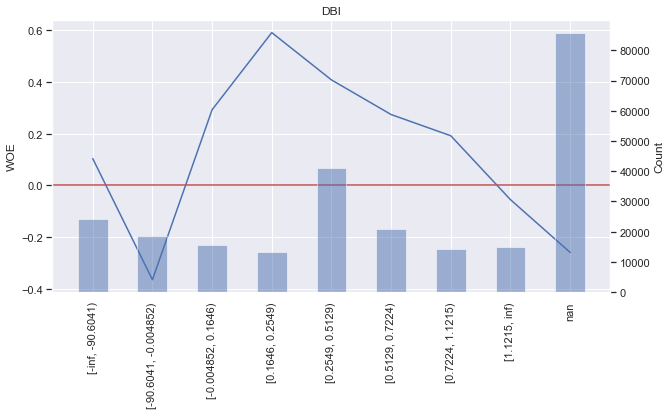

In [160]:
grouping.plot_bins(data=data, cols_pred_num=cols_pred_num, cols_pred_cat=cols_pred_cat,
                    mask=train_mask, col_target=col_target, output_folder=output_folder, col_weight=None)

## Add the transformed variables to the data set

### WOE variables

Add WOE variabes to the data set.

In [92]:
data.head()

,TIME_DECISION_DATE,DBI,RISK_FSTQPD30,BASE,DAY,MONTH,data_type,DBI_WOE
SKP_CREDIT_CASE,,,,,,,,
304771296,2020-06-02,-0.224220,0.0,1,20200602,202006,hoot,-0.360637
304879436,2020-06-02,3.871108,0.0,1,20200602,202006,hoot,-0.062213
305402347,2020-06-03,0.054039,0.0,1,20200603,202006,hoot,0.264774
305436020,2020-06-09,-0.319881,0.0,1,20200609,202006,hoot,-0.360637
305441848,2020-06-03,-0.076336,0.0,1,20200603,202006,hoot,-0.360637


In [93]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in data:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
data = data.drop(woe_columns_to_replace, axis='columns')
data = data.join(data_woe)

del data_woe
gc.collect()

print('Added WOE variables. Number of columns:',data.shape[1])
cols_woe = [s + '_WOE' for s in cols_pred]

Column DBI_WOE dropped as it already existed in the data set.
Added WOE variables. Number of columns: 8


### Dummy variables

**Optional.**

In [96]:
dummy_columns_to_replace = list()
for column in data_dummy.columns:
    if column in data:
        dummy_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
data = data.drop(dummy_columns_to_replace, axis='columns')
data = data.join(data_dummy)

del data_dummy
gc.collect()

print('Added dummy variables. Number of columns:',data.shape[1])

Added dummy variables. Number of columns: 17


#  Feature selection

First remove WOE variables with one WOE value only - they will have no predictive power.

In [97]:
cols_del = list()
for name, column in data[train_mask][cols_woe].iteritems():
    if (column.count() == 0) or (column.max() == column.min()):
        cols_del.append(name)
        cols_woe.remove(name)

if len(cols_del) > 0:
    print('Variables',cols_del,'will not be further used as they have only 1 unique WOE level.')
else:
    print('All predictors have more than 1 unique WOE level.')

All predictors have more than 1 unique WOE level.


## Predictor power analysis

Calculates IV and Gini of each predictor, sorts the predictors by their power. The power is calculated for each of the samples (train, validate, test, OOT, H.OOT). **If one or more of the samples are empty, comment the according part of the code.**

In [99]:
from scoring.metrics import iv,gini,lift

power_tab = []
for j in range(0,len(cols_woe)):
    power_tab.append({'Name':cols_woe[j]
                    ,'IV Train':iv(data.loc[train_mask,col_target],data.loc[train_mask,cols_woe[j]])
                    ,'Gini Train':gini(data.loc[train_mask,col_target],-data.loc[train_mask,cols_woe[j]])
                    ,'IV Validate':iv(data.loc[valid_mask,col_target],data.loc[valid_mask,cols_woe[j]])
                    ,'Gini Validate':gini(data.loc[valid_mask,col_target],-data.loc[valid_mask,cols_woe[j]])
                    ,'IV Test':iv(data.loc[test_mask,col_target],data.loc[test_mask,cols_woe[j]])
                    ,'Gini Test':gini(data.loc[test_mask,col_target],-data.loc[test_mask,cols_woe[j]])
#                     ,'IV OOT':iv(data.loc[oot_mask,col_target],data.loc[oot_mask,cols_woe[j]])
#                     ,'Gini OOT':gini(data.loc[oot_mask,col_target],-data.loc[oot_mask,cols_woe[j]])
#                     ,'IV HOOT':iv(data.loc[hoot_mask,col_target],data.loc[hoot_mask,cols_woe[j]])
#                     ,'Gini HOOT':gini(data.loc[hoot_mask,col_target],-data.loc[hoot_mask,cols_woe[j]])
                         })
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index('Name')
power_out = power_out.sort_values('Gini Train',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 15
power_out.to_csv(output_folder+'/predictors/covariates.csv')

,IV Train,Gini Train,IV Validate,Gini Validate,IV Test,Gini Test
Name,,,,,,
DBI_WOE,0.088683,0.162503,0.091709,0.154961,0.075923,0.146849


## Time stability of predictors

### Stability charts

Set metadata for the stability charts. Two types of charts will be drawn:
- Stability of default rate, for which the variables with default and with base need to be set
- Stability of population, for which the variable with observation count needs to be set

In [100]:
target_for_default = col_target
base_for_default = col_base
data['ones'] = 1
obs_for_population = col_base

In [101]:
data.head()

,TIME_DECISION_DATE,DBI,RISK_FSTQPD30,BASE,DAY,MONTH,data_type,DBI_WOE,DBI_DMY_0,DBI_DMY_1,DBI_DMY_2,DBI_DMY_3,DBI_DMY_4,DBI_DMY_5,DBI_DMY_6,DBI_DMY_7,DBI_DMY_NaN,ones
SKP_CREDIT_CASE,,,,,,,,,,,,,,,,,,
304771296,2020-06-02,-0.224220,0.0,1,20200602,202006,hoot,-0.360637,0,1,0,0,0,0,0,0,0,1
304879436,2020-06-02,3.871108,0.0,1,20200602,202006,hoot,-0.062213,0,0,0,0,0,0,0,1,0,1
305402347,2020-06-03,0.054039,0.0,1,20200603,202006,hoot,0.264774,0,0,1,0,0,0,0,0,0,1
305436020,2020-06-09,-0.319881,0.0,1,20200609,202006,hoot,-0.360637,0,1,0,0,0,0,0,0,0,1
305441848,2020-06-03,-0.076336,0.0,1,20200603,202006,hoot,-0.360637,0,1,0,0,0,0,0,0,0,1


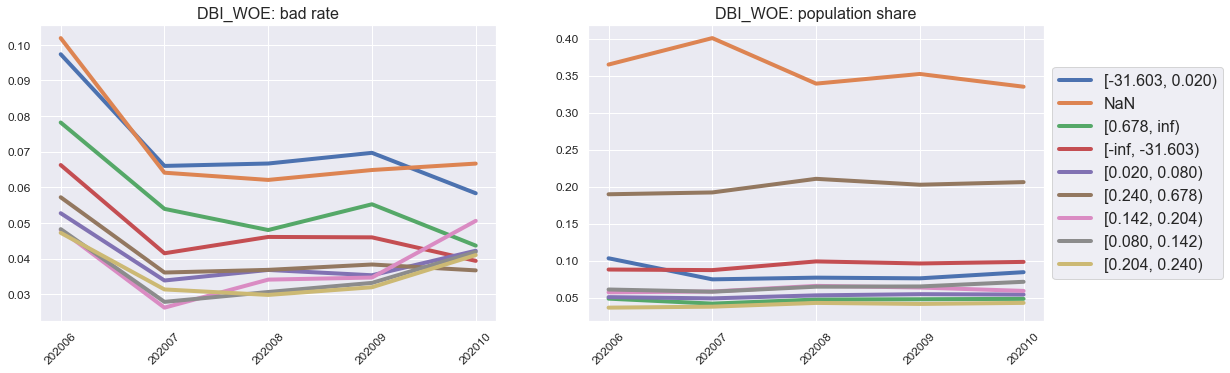

In [103]:
from scoring.plot import stability_chart

# clf = modelSW
list_pred = ['DBI_WOE']
# for col in list(clf.final_predictors_):
for col in list_pred:
    
    stability_chart(binvar = data[col],
                    target = data[target_for_default],
                    base = data[base_for_default],
                    obs = data[obs_for_population],
                    month = data[col_month],
#                    weight = data[col_weight],
                    grouping=grouping, # comment this out for old plots with WOE values
                    savepath = output_folder+'/stability/'+col+'_')

### Stability Index

The following code calculates two versions of Elena's Stability Index, which are defined as follows.

**v1** 
1. Compute the bad rates in each category for each month
2. Compute the rank of each category within each month based on the bad rate
3. Compute the frequency of each position / rank within each category from step 2
4. Compute the ratios of the most frequent position / rank within each category from step 3
5. Compute average of the ratios from step 4

**v2**
1. Compute the bad rates in each category for each month
2. Compute the rank of each category within each month based on the bad rate
3. Compute the frequency of each position / rank through all categories from step 2 and the corresponding ratios
4. Compute the product of the ratios within each position / rank from step 3
5. Compute average of the products from step 4

*Note: Both version can give "false positives" (indicating that variable is unstable) for U-shaped variables.*

In [113]:
from scoring.stability_index import stability_index_value

stability_tab = []

# for pred in clf.final_predictors_:
for pred in list_pred:

    for mask in ['train_mask', 'valid_mask', 'test_mask', 'oot_mask', 'hoot_mask']:
        for ver in ['v1', 'v2']:
            stability_tab.append({'Name':pred, 'Sample':mask[:-5], 'Index version':ver, 'Index value':
                                 stability_index_value(data[eval(mask)], pred, col_target, col_base, col_month)[ver]})

stability_tab = pd.DataFrame(stability_tab)
stability_tab = stability_tab.groupby(['Name','Index version','Sample'])[['Index value']].mean().unstack(level=[1,2])

pd.options.display.max_rows = 1000
display(stability_tab)
stability_tab.to_csv(output_folder+'/stability/stability_index.csv')

Index value                                                 \
Index version             v1                         v2                       
Sample                  hoot  oot test train valid hoot      oot test train   
Name                                                                          
AIRTEL_SCORE_WOE         1.0  1.0  0.6   0.8   0.5  1.0  0.00032  0.4   0.7   

                        
Index version           
Sample           valid  
Name                    
AIRTEL_SCORE_WOE  0.25

### PSI

In [114]:
from scoring.stability_index import psi_calc_df
monthly_psi, masked_psi = psi_calc_df(data, cols_pred_psi=list_pred, col_month='MONTH')
display(monthly_psi)

Month run: variable AIRTEL_SCORE_WOE is proceed. Done variables: 0/0


,Variable,PSI avg per month
0,AIRTEL_SCORE_WOE,0.030307
